**Pricing Analytics for a Container Leasing Company**

Inventory of Container Leasing Company:
https://docs.google.com/spreadsheets/d/1l_OJyHD1hTboVtuEfTInm-JeeAdbTN5Y/edit?gid=1736540494#gid=1736540494


Analysis of the Container Leasing Company's inventory reveals that demand is not fully met across various lease types — specifically the 1-week, 4-week, 8-week, and 16-week leases


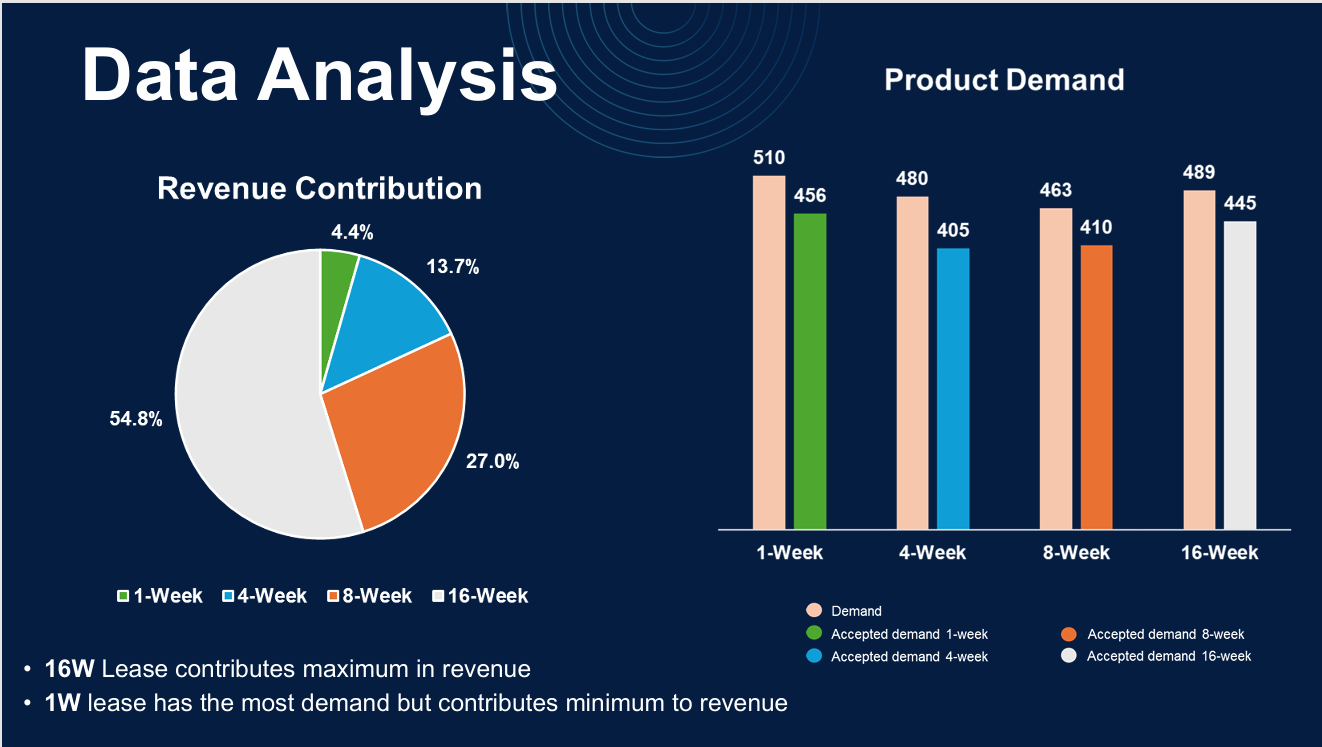


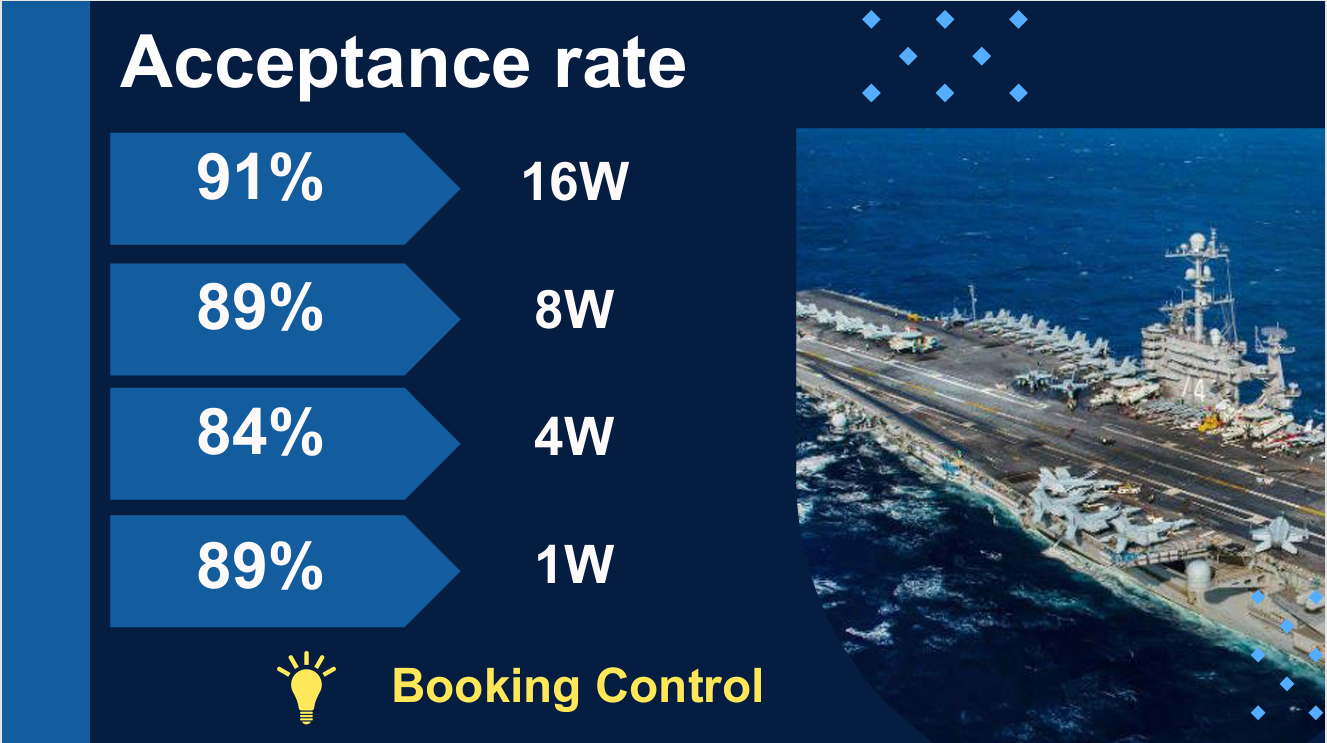

To address this, a linear optimization model has been developed that considers yearly demand and dynamically allocates containers to maximize profit. The results indicate that full utilization of demand can significantly enhance revenue. **Through efficient container allocation aligned with demand, revenue increased by approximately £70,000, rising from £679,000 to £749,588**.

Additionally, the load factor improved by 0.44, increasing from 5.72 to 6.16, suggesting that the fleet is being utilized more effectively. The revenue per container per year also rose from £2,263.64 to £2,496.67.

The initial Return on Investment (ROI) was calculated as:
2263.64 / 15000 = 15.09%
The improvement in ROI to 16.6% represents a 1.51% increase, underscoring the financial benefit of applying revenue management techniques. This demonstrates a more efficient use of WCG’s resources and a stronger return on investment.

**Constraints for the optimization models is given below**

Group 8 - Pricing Analytics

Decision Variables:
x[0:49,0:3] = Number of containers accepted for each week per lease duration.
inv[0:49] = Inventory for each week
Weeks are denoted from 0 to 49
lease duration is denoted as : 0 for 1-Week, 1 for 4-Week, 2 for 8-Week, 3 for 16-Week

Objective Function:
Max z = 7*x[0:49,0:3]*cost[0:49][0:3]*lease_duration[0:3]
cost[0:49,0:3] = cost per week for each lease duration from the given data
lease_duration[0:3] = lease duration i.e 1 for 1-Week,4 for 4-Week,8 for 8-Week,16 for 16-Week
which is used in the revenue calculation

Constraints:
Demand constraint:
    
    x[0:49,0:3] <= demand[0:49][0:3]
    demand[0:49][0:3] = demand per week for each lease duration from the given data

Inventory Constraint:
    
Inventory constraint for the 1st week taking into account the returned containers :
        
        inv[0] == 300 - sum(ret_last_yr[1:16][0:3])
        ret_last_yr[1:16][0:3] = containers returned from week 2 to 16 from the given data
        
  Inventory constraint for 2nd week to 4th week taking into account the returned containers and accepted containers :
        
        inv[1:3] == 300 - sum(ret_last_yr[1:16][0:3] ) + x[0:2,1:3])
        ret_last_yr[2:16][0:3] = containers returned from week 3 to 16 from the given data
        
  Inventory constraint for 5th week to 8th week taking into account the returned containers and accepted containers
        
        inv[4:7] == 300 - sum(ret_last_yr[6:16][0:3]) - sum(x[1:6,1])  + sum(model.x[0:6, 2:3])
        ret_last_yr[6:16][0:3] = containers returned from week 6 to 16 from the given data
        sum(x[1:6,1]) = returned containers from the previous weeks
        sum(model.x[0:6, 2:3]) = accepted containers from the previous weeks
    
  Inventory constraint for 9th week to 16th week taking into account the returned containers and accepted containers
        
        inv[8:15]== 300 - sum(ret_last_yr[10:16][0:3]) - sum(x[1:14,1:3])+ sum(x[0:14, 3])
        ret_last_yr[10:16][0:3] = containers returned from week 10 to 16 from the given data
        sum(x[1:14,1:3]) = returned containers from the previous weeks
        sum(x[0:14, 3]) = accepted containers from the previous weeks
    
  Inventory constraint for 17th week to 50th week taking into account the returned containers
       
       inv[16:49]== 300 - sum(x[1:49][1:3])
       x[1:49,1:3] = returned container from the previous weeks
       
  Total Capacity constraint
       
       sum(x[0:49][0:3]) <= 300
       
  Non-Negativity Constraints:
       
       x[0:49,0:3] >= 0
       inv[0:49] >=0

**Pricing Model to maximize revenue**

In [ ]:
#Libraries Import
from pyomo.environ import *
import pandas as pd
import numpy as np

#DataFrame Initialisation
df_pricing = pd.read_excel('WCG_DataSet.xlsx',index_col=0,sheet_name='WCG Data')

#Convert data from to numpy array
data_np = df_pricing.to_numpy()

#Data extraction
df = data_np[8:58,:19]
ret_last_yr = np.zeros((16, 4), dtype=int)
ret_last_yr[0, 0] = df[0,6]
ret_last_yr[0:4, 1] = df[0:4,10]
ret_last_yr[0:8, 2] = df[0:8, 14]
ret_last_yr[0:16, 3] = df[0:16, 18]
lease_duration = [1,4,8,16]

#Index for Weeks
index = range(len(df))

#Cost index
cost = df[:,[3,7,11,15]]
#Demand Index
demand=df[:,[4,8,12,16]]
len_week_index = range(len(cost[0,:]))

#Model and variable declarations
model = ConcreteModel()
model.x = Var(index,len_week_index, domain=NonNegativeReals)
model.inv=Var(index,domain=NonNegativeReals)

#Objective function
model.obj = Objective(expr=sum(7*model.x[i,j]*cost[i][j]*lease_duration[j] for i in index for j in len_week_index),sense=maximize)

#Demand Constraint
def demand_rule(model,i,j):
    return model.x[i,j] <= demand[i][j]

model.demmand=Constraint(index,len_week_index,rule=demand_rule)

# Inventory Constraint
## Inventory constraint for the 1st week taking into account the returned containers
def inv_rule_1(model,i):
        return model.inv[i] == 300 - sum(ret_last_yr[m][j] for m in range(1,16) for j in len_week_index)

model.constr1=Constraint(range(1),rule=inv_rule_1)

## Inventory constraint for 2nd week to 4th week taking into account the returned containers and accepted containers
def inv_rule_2(model,i):
        return model.inv[i] == 300 - sum(ret_last_yr[m][j] for m in range(i+1,16) for j in len_week_index) + sum(model.x[l,k] for l in range(0,i) for k in range(1,len(len_week_index)))

model.constr2=Constraint(range(1,4),rule=inv_rule_2)

## Inventory constraint for 5th week to 8th week taking into account the returned containers and accepted containers
def inv_rule_3(model,i):
        return model.inv[i] == 300 - sum(ret_last_yr[m][j] for m in range(i+1,16) for j in len_week_index) - sum(model.x[i-l,k] for k in range(1, len(len_week_index)-2) for l in range(1,lease_duration[k])) - sum(model.x[n, j] for n in range(0,i) for j in range(2, len(len_week_index)))

model.constr3=Constraint(range(4,8),rule=inv_rule_3)

## Inventory constraint for 9th week to 16th week taking into account the returned containers and accepted containers
def inv_rule_4(model,i):
        return model.inv[i] == 300 - sum(ret_last_yr[m][j] for m in range(i+1,16) for j in len_week_index) + sum(model.x[i-k,j] for j in range(1, len(len_week_index)-1) for k in range(1,lease_duration[j]))- sum(model.x[n, 3] for n in range(0,i))

model.constr4=Constraint(range(8,16),rule=inv_rule_4)

## Inventory constraint for 17th week to 50th week taking into account the returned containers
def inv_rule_5(model,i):
        return model.inv[i] == 300 - sum(model.x[i-k, j] for j in range(1, len(len_week_index)) for k in range(1,lease_duration[j]))
model.constr5=Constraint(range(16,len(index)),rule=inv_rule_5)

#Inventory constraint to check if the accepted containers are lesser than the inventory
def inventory_rule(model, i):
    return model.inv[i] >= sum(model.x[i, j] for j in len_week_index)

model.constr_inventory = Constraint(index, rule=inventory_rule)

#Total Capacity constraint
def total_cap_rule(model,i):
    return (sum(model.x[i,j] for j in len_week_index) <= 300)

model.constr_total_cap = Constraint(index, rule=total_cap_rule)

#Solver-solve the optimisiation problem
solver = SolverFactory('glpk')
results = solver.solve(model,load_solutions=False,tee=False)

if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    model.solutions.load_from(results)
else:
    print("Solve failed.")

#Overall revenue
print("Overall Revenue(in 1000s) is : £" , round(value(model.obj)/1000,2))

#Load factor
load_factor=0

for i in index:
    for j in len_week_index:
        load_factor = load_factor + value(model.x[i,j])

print("Load Factor is : ", round(load_factor/300,2))

#Return on Investment
ROI = round(value(model.obj)/300/15000,4)*100
print("Return on Investment : ", ROI,"%")

#Number of Orders in a week
for i in index:
    for j in len_week_index:
        print('The number of orders accepted in week', i+1, 'for a lease term of',lease_duration[j], ' weeks should be :', model.x[i,j]())

